In [1]:
import torch
import torch.nn as nn
import numpy as np
import json
from skimage.draw import polygon
from torchvision.models.detection.image_list import ImageList
from torch.utils.data import Dataset
from torchvision.models.detection import retinanet_resnet50_fpn_v2, RetinaNet_ResNet50_FPN_V2_Weights
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

In [2]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda"

device

'cuda'

In [3]:
N_ATT = 35 # this is an upper bound on the number of craters

In [4]:
MEAN=(0.485, 0.456, 0.406)
STD=(0.229, 0.224, 0.225)

In [5]:
# Remove the current ./dataset directory if it exists
# !rm -rf ./dataset

# Clone only the 'dataset' subdirectory from the GitHub repository
# !git clone --depth 1 --filter=blob:none --sparse https://github.com/aami-sagnik/lunar-crater-detection.git temp_repo
# !cd temp_repo && git sparse-checkout set dataset && mv dataset ../ && cd .. && rm -rf temp_repo

# Remove the current ./saved_weights directory if it exists
# !rm -rf ./saved_weights

# Clone only the 'saved_weights' subdirectory from the GitHub repository
# !git clone --depth 1 --filter=blob:none --sparse https://github.com/aami-sagnik/lunar-crater-detection.git temp_repo
# !cd temp_repo && git sparse-checkout set saved_weights && mv saved_weights ../ && cd .. && rm -rf temp_repo

In [6]:
class LunarCraterDataset(Dataset):
    image_transforms = transforms.Compose([
        transforms.Lambda(lambda img: img.convert("RGB")),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=MEAN,
            std=STD
        )
    ])

    def __init__(self, n_att, source_h, source_w, dataset_path="./dataset"):
        self.dataset_path = dataset_path
        self.n_att = n_att
        self.source_h = source_h
        self.source_w = source_w
        self.resize_transform = None

        # Collect all PNG image filenames in the dataset directory
        self.png_files = [f for f in os.listdir(dataset_path) if f.endswith(".png") and os.path.isfile(os.path.join(dataset_path, f))]

        self.print_info()

    def __len__(self):
        return len(self.png_files)

    def __getitem__(self, idx):
        # Lazy load image from disk
        img_path = os.path.join(self.dataset_path, self.png_files[idx])
        image = Image.open(img_path)
        image = self.image_transforms(image)

        # Lazy load corresponding masks from JSON
        json_file_base = self.png_files[idx].split(".png")[0]
        mask, num_mask = self.get_masks_from_json(
            os.path.join(self.dataset_path, f"{json_file_base}_annotations.json"),
            self.source_w, self.source_h, self.n_att
        )

        if self.resize_transform is not None:
            image = self.resize_transform(image)
            mask = self.resize_transform(mask)

        return image, mask

    def resize(self, h, w):
        LunarCraterDataset.resize_transform = transforms.Compose([
        transforms.Resize((h, w))
    ])

    def print_info(self):
        print(f"Number of images: {len(self.png_files)}")
        print(f"Number of masks per image (max {self.n_att})")
    
    def view(self, index):
        image, mask = self.__getitem__(index)
        LunarCraterDataset.view_image(image, mask)

    @staticmethod
    def view_image(image, masks=None, mean=MEAN, std=STD):
        denormalize = transforms.Normalize(
            mean=[-m/s for m, s in zip(mean, std)], 
            std=[1/s for s in std]
        )
        image = denormalize(image).detach().cpu()
        plt.imshow(torch.permute(image, (1, 2, 0)))

        if masks is not None:
            masks = masks.detach().cpu()
            n = masks.shape[0]
            colors = plt.get_cmap('hsv', n)
            for i in range(n):
                mask = masks[i].numpy()
                colored_mask = np.zeros((mask.shape[0], mask.shape[1], 4))
                colored_mask[:, :, :3] = colors(i)[:3]  # RGB
                colored_mask[:, :, 3] = mask * 0.4      # Alpha
                plt.imshow(colored_mask, interpolation='none')

        plt.show()

    @staticmethod
    def view_bbox(image, boxes, labels, mean=MEAN, std=STD, class_name="Crater"):
        targets_dict = {
            "boxes": boxes,
            "labels": labels
        }
        denormalize = transforms.Normalize(
            mean=[-m/s for m, s in zip(mean, std)], 
            std=[1/s for s in std]
        )
        img_array = denormalize(image).cpu().numpy().transpose(1, 2, 0)
        img_array = np.clip(img_array, 0, 1)
        boxes = targets_dict['boxes'].cpu().numpy()
        labels = targets_dict['labels'].cpu().numpy()
        H, W, C = img_array.shape

        fig, ax = plt.subplots(1, figsize=(10, 10))
        ax.imshow(img_array)

        for box, label in zip(boxes, labels):
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min - 5, f'{class_name} ({label})', color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.7, edgecolor='none'))

        ax.set_title(f"Image Visualization ({len(boxes)} detections)")
        plt.show()

    @staticmethod
    def get_masks_from_json(json_name, w, h, n_att):
        with open(json_name) as f:
            data_dict = json.load(f)
        base_name = json_name.split("/")[-1].split("_annotations.json")[0] + ".png"
        polygon_points = [e["points"] for e in data_dict.get(base_name, [])]
        num_masks = len(polygon_points)

        masks = torch.zeros((max(num_masks, n_att), w, h), dtype=torch.float)

        for i, points in enumerate(polygon_points):
            polygon_np = np.array(points)
            r = polygon_np[:, 1]
            c = polygon_np[:, 0]
            rr, cc = polygon(r, c, shape=(w, h))
            masks[i, rr, cc] = 1

        # Padding if num_masks < n_att
        return masks, num_masks


In [7]:
# Initialize Dataset and DataLoader
crater_dataset = LunarCraterDataset(n_att=N_ATT, source_h=1200, source_w=1200, dataset_path="./dataset")

Number of images: 51
Number of masks per image (max 35)


In [8]:
crater_dataset.resize(200, 200)
crater_dataset.print_info()

Number of images: 51
Number of masks per image (max 35)


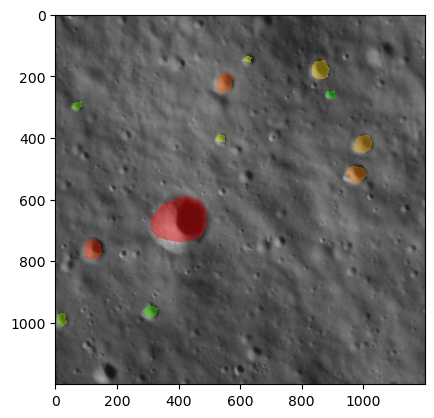

In [9]:
crater_dataset.view(0)

In [10]:
# Standard DataLoader is used as all items are now fixed-size tensors
train_dataloader = torch.utils.data.DataLoader(
    crater_dataset, 
    batch_size=2, 
    shuffle=True, 
)

In [11]:
def to_binary_masks(values):
    sm_values = torch.softmax(values, dim=1)
    max_indices = torch.argmax(sm_values, dim=1, keepdim=True)

    # Create a binary mask with 1 at max indices and 0 elsewhere
    binary_masks = torch.zeros_like(sm_values).scatter_(1, max_indices, 1)

    return binary_masks

In [12]:
def masks_to_targets(masks_batch, device):
    """
    Converts a batch of padded instance masks (B, N_ATT, H, W) into 
    a List[Dict] format required by the RetinaNet detection head.
    
    Bounding boxes are calculated from non-zero masks and returned in 
    the standard [x1, y1, x2, y2] format (absolute coordinates).
    Labels are fixed at 1 for all detected instances.
    """
    targets_list = []
    
    for i in range(masks_batch.shape[0]): # Loop through the batch
        masks = masks_batch[i] # (N_ATT, H, W)
        
        boxes = []
        labels = []
        
        # Iterate over up to N_ATT padded masks
        for j in range(masks.shape[0]):
            mask = masks[j]
            # Check if this mask is a valid instance (not a zero-padding mask)
            if mask.sum() > 1e-6:
                # Find coordinates of non-zero pixels
                # NOTE: torch.where returns two tuples: (y_coords, x_coords)
                ys, xs = torch.where(mask)
                
                # Bounding box in [x1, y1, x2, y2] format
                x_min = xs.min().item()
                y_min = ys.min().item()
                x_max = xs.max().item()
                y_max = ys.max().item()
                
                boxes.append([x_min, y_min, x_max, y_max])
                # Label is always 1 for the first object class (crater)
                labels.append(1)
        
        # Assemble tensors for the RetinaNet target dictionary
        if not boxes:
            # If no instances are present, create an empty tensor pair
            boxes_tensor = torch.zeros((0, 4), dtype=torch.float32, device=device)
            labels_tensor = torch.zeros((0,), dtype=torch.long, device=device)
        else:
            boxes_tensor = torch.as_tensor(boxes, dtype=torch.float32, device=device)
            labels_tensor = torch.as_tensor(labels, dtype=torch.long, device=device)

        targets_list.append({
            'boxes': boxes_tensor,
            'labels': labels_tensor
        })
        
    return targets_list

In [13]:
def _create_gt_panoptic_map(mod_masks_batch, n_att, n_stuff):
    """
    Constructs the Panoptic Ground Truth map (GT_pan) from the fixed-size 
    list of ground-truth masks (mod_masks), where each mask corresponds to 
    an output channel index.
    
    The mod_masks for one image should have shape (n_out, H, W).
    """
    
    gt_panoptic_maps = []
    
    # Total number of channels / masks to process
    n_out = n_att + n_stuff + 2 
    
    for mod_masks in mod_masks_batch:
        # mod_masks has shape (n_out, H, W). The masks are mutually exclusive.
        _, H, W = mod_masks.shape
        device = mod_masks.device
        
        # 1. Initialize GT map with the Unlabeled/Background index (the very last channel index)
        background_idx = n_out - 1
        gt_pan = torch.full((H, W), background_idx, dtype=torch.long, device=device)
        
        # 2. Iterate through all mask channels (excluding the last one which is the background itself)
        # and assign the corresponding channel index k to the map where the mask is active.
        for k in range(n_out - 1):
            mask = mod_masks[k].bool()
            gt_pan[mask] = k
            
        gt_panoptic_maps.append(gt_pan)

    return torch.stack(gt_panoptic_maps, dim=0)

In [14]:
WEIGHTS_DIR = './saved_weights'
WEIGHTS_FILENAME = 'crater_retinanet_weights.pth' 
SAVE_PATH = os.path.join(WEIGHTS_DIR, WEIGHTS_FILENAME)
state_dict = torch.load(SAVE_PATH)

In [15]:
class FPSNet(nn.Module):
    def __init__(self, n_att=5, n_stuff=1, c_att=50, retina_net_state=None):
        super(FPSNet, self).__init__()
        retina_net_weights = RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT
        self.retina_net = retinanet_resnet50_fpn_v2(weights=retina_net_weights)
        
        FINAL_OUTPUT_CLASSES = 1 + 1 # 1 - crater, 1 - background

        original_head = self.retina_net.head.classification_head
        num_anchors = original_head.num_anchors # Usually 9

        # Determine the input channels to the final classification layer (C=256 in FPN architecture [4, 8])
        num_in_channels = original_head.cls_logits.in_channels 

        # Re-initialize the final convolutional layer to match the new output size (2 classes * num_anchors)
        self.retina_net.head.classification_head.cls_logits = torch.nn.Conv2d(
            num_in_channels,
            FINAL_OUTPUT_CLASSES * num_anchors, 
            kernel_size=3,
            stride=1,
            padding=1
        ).to(device)

        prior_prob = 0.01
        bias_value = -torch.log(torch.tensor((1 - prior_prob) / prior_prob))
        torch.nn.init.constant_(self.retina_net.head.classification_head.cls_logits.bias, bias_value)
        self.retina_net.head.classification_head.num_classes = FINAL_OUTPUT_CLASSES

        if retina_net_state is not None:
            self.retina_net.load_state_dict(state_dict)
        
        for name, param in self.retina_net.named_parameters():
            if 'backbone' in name:
                param.requires_grad = False

        self.fpn = self.retina_net.backbone
        self.upsample_f_5 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding="same"),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(128, 128, 3, padding="same"),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        )
        self.upsample_f_4 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding="same"),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        )
        self.upsample_f_3 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding="same"),
            nn.ReLU(),
        )
        self.detection_head = self.retina_net.head
        self.anchor_generator = self.retina_net.anchor_generator
        self.postprocess_detections = self.retina_net.postprocess_detections
        self.n_att = n_att
        self.n_stuff = n_stuff
        self.n_out = n_att + n_stuff + 2 # things with ids (n_att) + stuff (n_stuff) + unmatched things (1) + unlabelled pixels(1)
        self.c_att = c_att
        # self.retina_net.score_thresh = 0.22

        self.pre_panoptic_head = nn.Sequential(
            nn.Conv2d(128 + self.n_att, 128, 3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.panoptic_head = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 128, 3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 128, 3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 128, 3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, self.n_out, 1)
        )

        self.max_int = torch.iinfo(torch.int).max

    def to_single_fmap(self, fmaps):
        f_3 = fmaps[0]
        f_4 = fmaps[1]
        f_5 = fmaps[2]

        resized_maps = [
            self.upsample_f_3(f_3),
            self.upsample_f_4(f_4),
            self.upsample_f_5(f_5),
        ]

        # Find minimum height and width
        min_h = min([f.shape[2] for f in resized_maps])
        min_w = min([f.shape[3] for f in resized_maps])

        # Crop to same size
        cropped_maps = [f[..., :min_h, :min_w] for f in resized_maps]

        aggregated_map = sum(cropped_maps)
        return aggregated_map


    def generate_detections(self, fmaps, images):
        head_outputs = self.detection_head(fmaps)

        image_sizes = [(img.shape[1], img.shape[2]) for img in images]
        image_list = ImageList(images, image_sizes)

        anchors = self.anchor_generator(image_list, fmaps)

        num_anchors_per_level = [x.size(2) * x.size(3) for x in fmaps]
        HW = 0
        for v in num_anchors_per_level:
            HW += v
        HWA = head_outputs["cls_logits"].size(1)
        A = HWA // HW
        num_anchors_per_level = [hw * A for hw in num_anchors_per_level]

        # split outputs per level
        split_head_outputs: dict[str, list[torch.Tensor]] = {}
        for k in head_outputs:
            split_head_outputs[k] = list(head_outputs[k].split(num_anchors_per_level, dim=1))
        split_anchors = [list(a.split(num_anchors_per_level)) for a in anchors]

        # compute the detections
        detections = self.postprocess_detections(split_head_outputs, split_anchors, image_list.image_sizes)

        return detections

    def soft_attention_mask(self, mu, C, box_dim, mask_w, mask_h):
        # mu: (2,) tensor, C: (2,2) tensor, w, h, n: ints

        # Create n x n grid
        ys = torch.arange(mask_h, dtype=torch.float32).to(mu.device)
        xs = torch.arange(mask_w, dtype=torch.float32).to(mu.device)
        grid_y, grid_x = torch.meshgrid(ys, xs, indexing='ij')
        coords = torch.stack([grid_y, grid_x], dim=-1)  # shape: (n, n, 2)

        # Bounding box coordinates
        y1 = int(mu[0] - box_dim[1] // 2)
        y2 = int(mu[0] + box_dim[1] // 2)
        x1 = int(mu[1] - box_dim[0] // 2)
        x2 = int(mu[1] + box_dim[0] // 2)

        # Mask for bounding box: True inside the box
        mask_box = (
            (grid_y >= y1) & (grid_y < y2) &
            (grid_x >= x1) & (grid_x < x2)
        )

        # Flatten grid for Gaussian
        coords_flat = coords.reshape(-1, 2)  # (n*n, 2)
        mvn = torch.distributions.MultivariateNormal(mu, C)
        gauss_flat = torch.exp(mvn.log_prob(coords_flat))  # (n*n,)

        # Restore mask shape
        gauss_mask = gauss_flat.reshape(mask_w, mask_h)
        gauss_mask *= mask_box  # zero outside the bounding box

        # Normalize soft mask
        sum_gauss = gauss_mask.sum()
        gauss_mask /= (sum_gauss + 1e-7)

        return gauss_mask
    
    def iou_binary_masks(self, mask1, mask2):
        mask1 = mask1.to(torch.bool)
        mask2 = mask2.to(torch.bool)
        intersection = (mask1 & mask2).float().sum(dim=(-2, -1))
        union = (mask1 | mask2).float().sum(dim=(-2, -1))
        iou = intersection / (union + 1e-7)
        return iou
    
    def rearrange_actual_masks_iou(self, actual_masks, predicted_masks, predicted_labels, iou_thresh=0.5):
        if self.training:
            iou_thresh = 0
        taken = torch.zeros(len(predicted_masks))
        chosen = torch.zeros(len(actual_masks)) - 1
        
        for i in range(len(actual_masks)):
            actual_mask = actual_masks[i]
            max_iou = 0
            selected = self.max_int
            for j in range(len(predicted_masks)):
                predicted_mask = predicted_masks[j]

                if predicted_labels[j] == -1: # these are zero-value masks for padding
                    continue

                predicted_mask = predicted_mask.unsqueeze(0).unsqueeze(0)
                predicted_mask = F.interpolate(predicted_mask, size=actual_mask.shape, mode='nearest')
                predicted_mask = predicted_mask.squeeze(0).squeeze(0)
                
                iou = self.iou_binary_masks(actual_mask, predicted_mask)

                if iou > iou_thresh and iou > max_iou and taken[j] == 0:
                    max_iou = iou
                    selected = j
                    taken[j] = 1

            chosen[i] = selected

        indices = chosen.argsort()
        return (actual_masks[indices], chosen[indices])
    
    def get_unlabeled_mask(self, matched_masks, aggregated_unmatched_mask):
        all_masks = torch.cat([matched_masks, aggregated_unmatched_mask], dim=0)  # Shape: (n_att+1, h, w)

        # Compute pixel-wise logical OR across the first dimension (all masks combined)
        combined_mask = torch.any(all_masks.bool(), dim=0)  # Shape: (h, w), bool

        # Invert the combined mask to get unlabeled mask
        unlabeled_mask = ~combined_mask  # bool, True where no mask is 1
        unlabeled_mask = unlabeled_mask.unsqueeze(0).to(matched_masks.dtype)
        return unlabeled_mask

    def generate_attention_masks(self, boxes, scores, labels, ms_w, ms_h, h_sf, w_sf, actual_masks=None):
        # x_sf, y_sf represent the x and y scaling factors respectively
        # x_sf * x_image_space = x_mask_space
        # y_sf * y_image_space = y_mask_space

        attention_masks = []
        attention_labels = []
        attention_scores = []

        included = 0

        for _ in range(self.n_att):
            if included < boxes.shape[0]:
                box = boxes[included]
                score = scores[included]
                label = labels[included]

                mean = torch.Tensor([box[0].item()*h_sf, box[1].item()*w_sf]).to(device)
                mean = torch.floor(mean).to(device)
                box_dim = torch.Tensor([box[2].item()*h_sf, box[3].item()*w_sf]).to(device)
                box_dim = torch.floor(box_dim)

                C = torch.diag(box_dim).to(device)

                # this prevents C from having a zero determinant if box_dim is [0, x] or [x, 0]
                C = C + torch.eye(C.shape[0]).to(device) * 1e-7

                attention_mask = self.soft_attention_mask(mean, C, box_dim, ms_w, ms_h)

                attention_masks.append(attention_mask)
                attention_labels.append(label.to(device))
                attention_scores.append(score)

                included += 1
            else:
                attention_masks.append(torch.zeros(ms_w, ms_h).to(device))
                attention_labels.append(torch.tensor(-1).to(device))
                attention_scores.append(torch.tensor(0).to(device))

        attention_masks = torch.stack(attention_masks).to(device)
        attention_labels = torch.stack(attention_labels).to(device)
        attention_scores = torch.stack(attention_scores).to(device)

        indices = torch.randperm(attention_masks.size(0))

        attention_masks = attention_masks[indices]
        attention_labels = attention_labels[indices]
        attention_scores = attention_scores[indices]
        attention_masks *= self.c_att

        # during training, we need to rearrange the "things" in the input masks tensor according to the attention masks generated here
        if self.training:
            rearranged_masks, chosen = self.rearrange_actual_masks_iou(actual_masks, attention_masks, attention_labels)

            matched_mask_indices = (chosen != self.max_int).nonzero(as_tuple=True)[0]
            matched_masks = rearranged_masks[matched_mask_indices]

            # Pad matched_masks if less than n_att
            num_matched = matched_masks.size(0)
            if num_matched < self.n_att:
                padding = torch.zeros((self.n_att - num_matched, matched_masks.size(1), matched_masks.size(2)), dtype=matched_masks.dtype, device=matched_masks.device)
                matched_masks = torch.cat([matched_masks, padding], dim=0)
            else:
                # Optionally trim if more than n_att
                matched_masks = matched_masks[:self.n_att]

            # unmatched: actual masks without any corresponding predicted mask
            unmatched_mask_indices = (chosen == self.max_int).nonzero(as_tuple=True)[0]
            unmatched_masks = rearranged_masks[unmatched_mask_indices]

            aggregated_unmatched_mask = torch.any(unmatched_masks.bool(), dim=0).to(unmatched_masks.dtype).unsqueeze(0)

            unlabeled_mask = self.get_unlabeled_mask(matched_masks, aggregated_unmatched_mask)

            # Append aggregated unmatched mask to matched_masks
            new_actual_masks = torch.cat([matched_masks, aggregated_unmatched_mask, unlabeled_mask], dim=0)

            mask = torch.zeros(attention_masks.size(0), dtype=torch.bool, device=attention_masks.device)
            mask[chosen[chosen != self.max_int].long()] = True

            # Zero out attention masks not in chosen
            attention_masks = attention_masks * mask.unsqueeze(1).unsqueeze(2).to(attention_masks.dtype)

            return (attention_masks, attention_labels, attention_scores, new_actual_masks)
        
        return (attention_masks, attention_labels, attention_scores, None)

    def forward(self, images, actual_masks=None, retinanet_targets=None):
        if self.training and retinanet_targets is not None:
            # When targets are present, retina_net's forward returns a dict of losses
            retina_output = self.retina_net(images, targets=retinanet_targets)
            
            # Get FPN features
            fp = self.fpn(images)
            fmaps = list(fp.values())
            
            # Generate detections (needed for the Panoptic Head's attention mask generation)
            detections = self.generate_detections(fmaps, images)
            detection_loss = retina_output

        # If targets are not provided (during inference or just the panoptic path)
        else:
            # Standard FPSNet forward: run FPN, then generate detections manually
            fp = self.fpn(images)
            fmaps = list(fp.values())
            detections = self.generate_detections(fmaps, images)
            detection_loss = {}

        aggregated_maps = self.to_single_fmap(fmaps) # scaling and adding the feature maps to get a single feature map

        panoptic_features = []
        panoptic_labels = []
        panoptic_scores = []

        h = images.shape[2]
        w = images.shape[3]

        h_mask_sf = aggregated_maps.shape[2] / h
        w_mask_sf = aggregated_maps.shape[3] / w

        modified_actual_masks = None
        if self.training:
            modified_actual_masks = []

        for i in range(images.shape[0]):
            detection = detections[i]
            aggregated_map = aggregated_maps[i]
            
            actual_mask = None
            if self.training:
                actual_mask = actual_masks[i]

            # "detection" represents boxes for one image in a batch
            # "aggregated_map" represents feature map for one image in a batch
            boxes = detection["boxes"]
            scores = detection["scores"]
            labels = detection["labels"]
            attention_masks, attention_labels, attention_scores, new_actual_mask = self.generate_attention_masks(boxes, scores, labels, aggregated_map.shape[1], aggregated_map.shape[2], h_mask_sf, w_mask_sf, actual_masks=actual_mask) # generating attention masks from bounding boxes

            if self.training:
                modified_actual_masks.append(new_actual_mask)

            panoptic_feature_single = torch.cat([attention_masks, aggregated_map], dim=0) # generating panoptic features for one image

            # for batch processing multiple images at a time
            panoptic_features.append(panoptic_feature_single)
            panoptic_labels.append(attention_labels)
            panoptic_scores.append(attention_scores)

        panoptic_features = torch.stack(panoptic_features)
        if self.training:
            modified_actual_masks = torch.stack(modified_actual_masks)

        panoptic_features = self.pre_panoptic_head(panoptic_features)
        output = self.panoptic_head(panoptic_features)

        upscaled_output = F.interpolate(output, size=(h, w), mode='bilinear', align_corners=False)

        result = {
            "values": upscaled_output,
            "labels": panoptic_labels,
            "scores": panoptic_scores,
            "boxes": [detection["boxes"] for detection in detections],
            "mod_masks": modified_actual_masks
        }
        result.update(detection_loss)

        return result

In [16]:
model = FPSNet(n_att=N_ATT, n_stuff=0, c_att=50, retina_net_state=state_dict).to(device) # instantiating the model
model.eval()

FPSNet(
  (retina_net): RetinaNet(
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentu

In [17]:
num_epochs = 20

params_to_optimize = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params_to_optimize, lr=0.1)
model.train()

print(f"Starting training on device: {device}")

for epoch in range(num_epochs):
    total_loss = 0
    
    # Dataloader yields (images, actual_masks_tensor)
    for batch_idx, (images, actual_masks_tensor) in enumerate(train_dataloader):
        # 1. Prepare Data
        images = images.to(device)
        actual_masks_tensor = actual_masks_tensor.to(device) 
        
        # --- DYNAMIC TARGET GENERATION ---
        # Generate the List[Dict] format detection targets from the ground truth masks
        targets_list = masks_to_targets(actual_masks_tensor, device)
        # --- END DYNAMIC TARGET GENERATION ---

        # 2. Forward Pass (Calculates both detection outputs and panoptic features)
        output = model(images, actual_masks=actual_masks_tensor, retinanet_targets=targets_list)
        
        # 3. Calculate Total Loss
        # A. Panoptic Cross-Entropy Loss (L_PCE)
        mod_masks_batch = output['mod_masks']
        gt_pan_map = _create_gt_panoptic_map(mod_masks_batch, N_ATT, 0)
        
        loss_panoptic = F.cross_entropy(output['values'], gt_pan_map.to(torch.long))
        
        # B. Detection Loss (L_DET) - Calculated internally by RetinaNet
        loss_detection_cls = output['classification']
        loss_detection_box = output['bbox_regression']
        
        loss_detection = loss_detection_cls + loss_detection_box

        # C. Total Loss 
        loss = loss_panoptic + 0.5 * loss_detection
        # 4. Backward Pass and Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}")
            print(f"  Total Loss: {loss.item():.4f} | PCE: {loss_panoptic.item():.4f} | CLS: {loss_detection_cls.item():.4f} | BOX: {loss_detection_box.item():.4f}")

    avg_loss = total_loss / len(train_dataloader)
    print(f"--- Epoch {epoch+1} finished. Avg Loss: {avg_loss:.4f} ---")

model.eval()

print(f"Training complete")

Starting training on device: cuda


OutOfMemoryError: CUDA out of memory. Tried to allocate 408.00 MiB. GPU 0 has a total capacity of 3.68 GiB of which 317.62 MiB is free. Including non-PyTorch memory, this process has 3.36 GiB memory in use. Of the allocated memory 3.06 GiB is allocated by PyTorch, and 163.71 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

torch.Size([3, 600, 600])


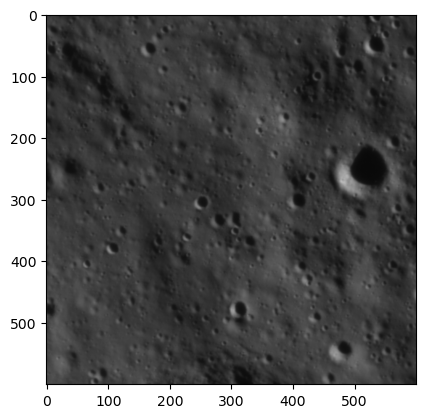

In [ ]:
output = None
test_image, test_mask = crater_dataset[0]
test_image.unsqueeze(0).to(device)
print(test_image.shape)
with torch.inference_mode():
    output = model(test_image.unsqueeze(0).to(device))
    binary_masks = to_binary_masks(output["values"])
    LunarCraterDataset.view_image(test_image, binary_masks[0, 0:N_ATT])

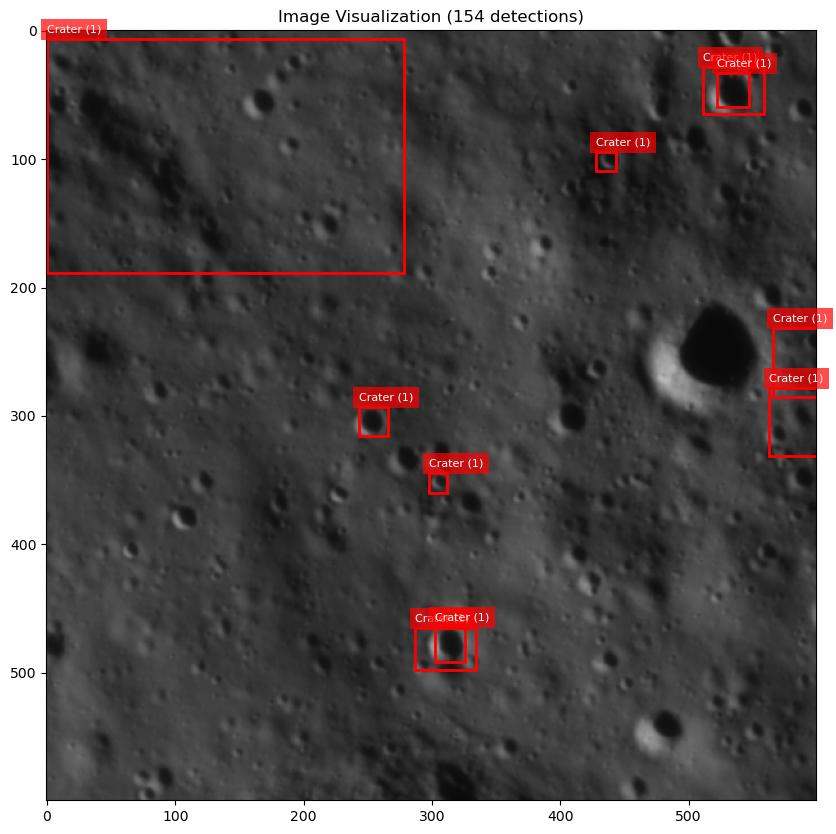

In [ ]:
LunarCraterDataset.view_bbox(test_image, output["boxes"][0], output["labels"][0])

torch.Size([3, 600, 600])


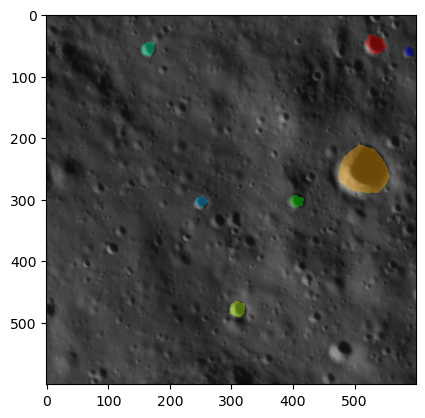

In [ ]:
crater_dataset.view(0)